# Libraries

In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from sklearn.neighbors import KDTree
import joblib
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

Using TensorFlow backend.


In [2]:
from tqdm.notebook import tqdm

In [3]:
import IPython.display as ipd

In [4]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [5]:
import sys
sys.path.insert(1, '../Images')
import utils_2d

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Images/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

## Load models

We only load the model with the best retrieval scores from the last notebook:

In [7]:
models_dir = "../Images/models"
model_number = "30"
simple_model, labels, simple_prep_fun = utils_2d.load_model(model_number, models_dir)

In [8]:
mask = utils_2d.create_mask()
new_width = 100

def simple_preprocessing(img):
    img = img[:,:,::-1].astype('uint8')
    gray = utils_2d.preprocess_img(img, mask, new_width, detector, fa)
    gray = simple_prep_fun(gray)
    return gray

## Load Features Functions

In [9]:
def compute_features(img, model, preprocessing):
    img = kimage.img_to_array(img)
    img = preprocessing(img)
    if len(img.shape) == 3:
        x = img[np.newaxis, :,:,:]
    else:
        x = img[np.newaxis,:,:,np.newaxis] 
    f = model.predict(x)
    return f.flatten()

In [10]:
# Data loader
def load_data(base_path, model, preprocessing, pics_per_person=3, color_mode = "rgb",
              target_size=(224,224), file_formats=["png", "jpg"], folders = None, np_seed = 0):

    paths = []
    features = []
    if folders is None:
        folders = os.listdir(base_path)
    for folder in tqdm(folders):
        #print(folder)
        path = base_path + "/" + folder
        if os.path.isdir(path):
            filenames = os.listdir(path)
            np.random.seed(np_seed)
            random_filenames = np.random.choice(filenames,
                                                np.min([len(filenames), pics_per_person]),
                                                replace=False)
            for f in sorted(random_filenames):
                if (f[-3:] in file_formats):
                    # Memorizza percorso file
                    cur_path = path+"/" + f
                    paths.append(cur_path)
                    # Carica file ed estraine le features
                    image = kimage.load_img(cur_path, target_size=(224, 224), color_mode = color_mode)
                    cur_features = compute_features(image, model, preprocessing)
                    features.append(cur_features)

    features = np.array(features)
    return features, np.array(paths)

# Retrieval - Celebrities pictures

In [11]:
path = "celebrities_full/"

In [12]:
classes = sorted(os.listdir(path))

In [13]:
len(classes)

1580

In [14]:
classes[:5]

['50 cent', 'aamir khan', 'aaron carter', 'aaron eckhart', 'abhishek bachchan']

There are 1580 classes.

We are going to compute features for 50 random pictures for each class.

In [15]:
pics_per_person = 30

We discard classes with less than 30 pictures:

In [16]:
classes = [cls for cls in classes if len(os.listdir(path+cls)) >= pics_per_person]

In [17]:
len(classes)

1514

In [18]:
classes[:5]

['50 cent', 'aamir khan', 'aaron carter', 'aaron eckhart', 'abhishek bachchan']

1514 classes remain

In [21]:
%%time
simple_X_train, paths = load_data(path, simple_model, simple_preprocessing,
                                  pics_per_person=pics_per_person, folders=classes)

/home/gian/anaconda3/envs/dsim/lib/python3.7/site-packages/PIL/TiffImagePlugin.py:802: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))



CPU times: user 3h 13min 12s, sys: 5h 17min 27s, total: 8h 30min 39s
Wall time: 1h 6min 21s


We save the features and paths:

In [22]:
np.save("simple_X_train_30ppp", simple_X_train)
np.save("paths_30ppp", paths)

In [23]:
paths = np.load("paths_30ppp.npy")
simple_X_train = np.load("simple_X_train_30ppp.npy")

## Albero di ricerca

In [24]:
simple_X_train.shape

(43611, 8)

In [25]:
%%time
tree = KDTree(simple_X_train)

CPU times: user 57.6 ms, sys: 96.1 ms, total: 154 ms
Wall time: 46.6 ms


In [26]:
def plot_imgs(paths, ind, n_imgs = 10, title = None):
    
    Tot = n_imgs
    Cols = 5
    Rows = Tot // Cols
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(figsize = (15,3 * Rows))
    # fig = plt.figure()
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(n_imgs):
        path = paths[ind[0][i]]
        vip_name = path.split("/")[-2]
        img=kimage.load_img(paths[ind[0][i]])
        
        ax = fig.add_subplot(Rows,Cols,Position[i])
        ax.axis('off')
        ax.set_title(f"{i+1}: {vip_name}")
        ax.imshow(img)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Example Query #1

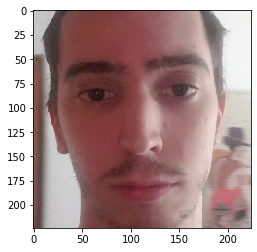

In [27]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"gian/gian_1.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

In [28]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.15 µs


Interrogo l'albero di ricerca

In [29]:
%%time
dist, ind = tree.query(simple_query_features.reshape(1, -1), k=10)

CPU times: user 910 µs, sys: 1.5 ms, total: 2.41 ms
Wall time: 350 µs


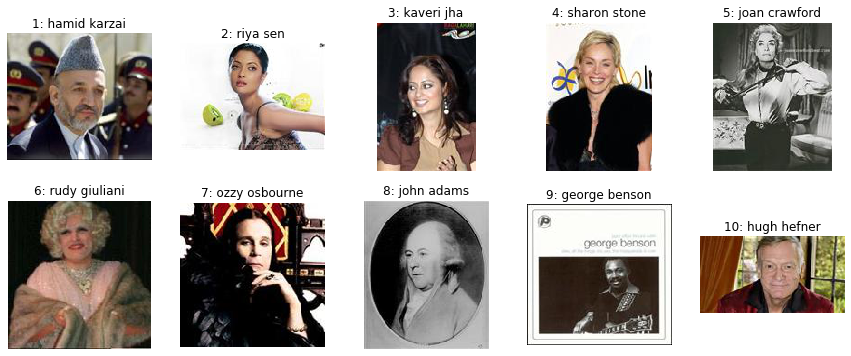

In [30]:
plot_imgs(paths, ind)

## Query #2

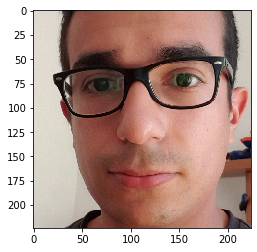

In [31]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"khaled/khaled_1.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

Interrogo l'albero di ricerca

In [32]:
%time
simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)
dist, ind = tree.query(simple_query_features.reshape(1, -1), k=10)

CPU times: user 2 µs, sys: 1 µs, total: 3 µs
Wall time: 6.2 µs


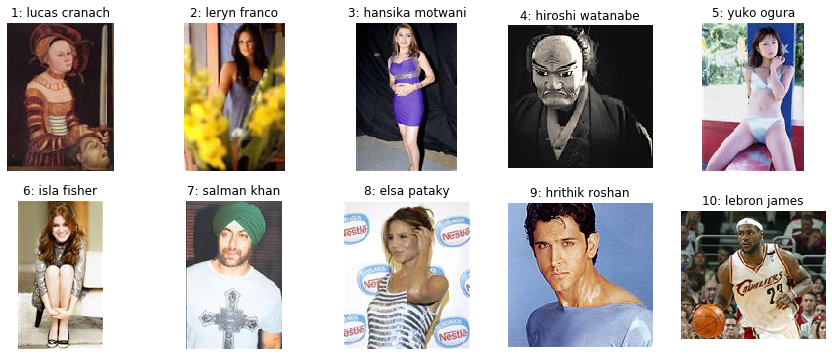

In [33]:
plot_imgs(paths, ind)

# Query all pictures for each person

We now query all pictures for:

- Alessandro,
- Alinda,
- Cami,
- Gian,
- Khaled,
- Luca,
- Mamma,
- Papi,

take the mode of the first ten retrieved celebrities, and count how many times each celebrity is considered the most similar.

In [34]:
from scipy.stats import mode

In [35]:
def query_all_pictures(cls, classes, test_dir = "../Images/test_pictures/"):
    query_pictures = [test_dir+cls+"/"+f for f in os.listdir(test_dir+cls)]
    d = {}
    for cel in classes:
        d[cel] = 0
    maxl = np.max([len(cel) for cel in classes ]) + 1
        
    tot = len(query_pictures)
    i = 0
    for file in query_pictures:
        i+=1
        img =  kimage.load_img(file, target_size=(224, 224))
        simple_query_features = compute_features(kimage.img_to_array(img), simple_model, simple_preprocessing)
        dist, ind = tree.query(simple_query_features.reshape(1, -1), k=10)
        predicted = np.array(paths)[ind[0]]
        predicted = [p.split("/")[-2] for p in predicted]
        if np.max(np.unique(predicted, return_counts=True)[1]) > 1:
            predicted = mode(predicted)[0][0]
        else:
            # otherwise we take the most similar
            predicted = predicted[0]
        d[predicted] += 1
        ipd.clear_output(wait=True)
        
        print(cls)
        print("Query #{}/{}\n".format(i, tot))
        
        print(f"{'':{maxl}s}  {'counts':},  {'percent'}")
        for j in sorted(d.keys(), key = lambda x : -d[x])[:10]:
            # print("{:14s}: {:3d}, {:>02.2f}%".format(j, d[j], d[j]/i*100))
            print(f"{j:{maxl}s}: {d[j]:6d}, {d[j]/i*100:>7.2f}%")

In [36]:
%%time
query_all_pictures("alessandro", classes)

alessandro
Query #394/394

                        counts,  Percent
isabelle adjani       :      7,    1.78%
matthew fox           :      6,    1.52%
franz kafka           :      5,    1.27%
johnny mathis         :      5,    1.27%
charlie sheen         :      4,    1.02%
david boreanaz        :      4,    1.02%
ian somerhalder       :      4,    1.02%
james mcavoy          :      4,    1.02%
mark twain            :      4,    1.02%
matt dillon           :      4,    1.02%
CPU times: user 2min 1s, sys: 3min 24s, total: 5min 26s
Wall time: 42.5 s


In [44]:
%%time
query_all_pictures("alinda", classes)

alinda
Query #138/138

                        counts,  Percent
franz schubert        :      3,    2.17%
caprice bourret       :      2,    1.45%
du bois               :      2,    1.45%
gerard butler         :      2,    1.45%
ian mckellen          :      2,    1.45%
kevin smith           :      2,    1.45%
leighton meester      :      2,    1.45%
michael phelps        :      2,    1.45%
michelle rodriguez    :      2,    1.45%
shayne ward           :      2,    1.45%
CPU times: user 29.5 s, sys: 52 s, total: 1min 21s
Wall time: 10.7 s


In [45]:
%%time
query_all_pictures("cami", classes)

cami
Query #220/220

                        counts,  Percent
gordon ramsay         :      6,    2.73%
ivanka trump          :      5,    2.27%
rose mcgowan          :      5,    2.27%
sienna guillory       :      4,    1.82%
alyson hannigan       :      3,    1.36%
dionne warwick        :      3,    1.36%
emma roberts          :      3,    1.36%
emmylou harris        :      3,    1.36%
lynda carter          :      3,    1.36%
norah jones           :      3,    1.36%
CPU times: user 1min 7s, sys: 1min 56s, total: 3min 4s
Wall time: 24.6 s


In [46]:
%%time
query_all_pictures("gian", classes)

gian
Query #234/234

                        counts,  Percent
mona lisa             :      5,    2.14%
annie lennox          :      3,    1.28%
benazir bhutto        :      3,    1.28%
demi moore            :      3,    1.28%
javier bardem         :      3,    1.28%
luciano pavarotti     :      3,    1.28%
maria grazia          :      3,    1.28%
takeshi kitano        :      3,    1.28%
alanis morissette     :      2,    0.85%
alessandra ambrosio   :      2,    0.85%
CPU times: user 1min 31s, sys: 2min 40s, total: 4min 12s
Wall time: 34.8 s


In [47]:
%%time
query_all_pictures("khaled", classes)

khaled
Query #308/308

                        counts,  Percent
michelle rodriguez    :     10,    3.25%
taylor swift          :      9,    2.92%
miranda lambert       :      7,    2.27%
gaspard ulliel        :      6,    1.95%
tyler perry           :      5,    1.62%
doutzen kroes         :      4,    1.30%
eddie murphy          :      4,    1.30%
kevin federline       :      4,    1.30%
prime minister        :      4,    1.30%
robert pattinson      :      4,    1.30%
CPU times: user 2min 4s, sys: 3min 36s, total: 5min 41s
Wall time: 45.8 s


In [48]:
%%time
query_all_pictures("luca", classes)

luca
Query #550/550

                        counts,  Percent
theodore roosevelt    :     57,   10.36%
amy grant             :     15,    2.73%
bridget moynahan      :     10,    1.82%
kenny rogers          :     10,    1.82%
ben harper            :      8,    1.45%
kevin smith           :      7,    1.27%
scarlett johansson    :      7,    1.27%
christopher walken    :      6,    1.09%
jessica stam          :      6,    1.09%
kenny g               :      6,    1.09%
CPU times: user 3min 8s, sys: 5min 24s, total: 8min 33s
Wall time: 1min 8s


In [49]:
%%time
query_all_pictures("mamma", classes)

mamma
Query #711/711

                        counts,  Percent
maggie gyllenhaal     :     13,    1.83%
arjun rampal          :      9,    1.27%
demi lovato           :      9,    1.27%
diana ross            :      9,    1.27%
gillian anderson      :      9,    1.27%
john singer           :      9,    1.27%
evo morales           :      8,    1.13%
che guevara           :      6,    0.84%
kimi raikkonen        :      6,    0.84%
mika nakashima        :      6,    0.84%
CPU times: user 3min 35s, sys: 6min 5s, total: 9min 41s
Wall time: 1min 17s


In [50]:
%%time
query_all_pictures("papi", classes)

papi
Query #362/362

                        counts,  Percent
jim brickman          :      5,    1.38%
buddy holly           :      4,    1.10%
ernest hemingway      :      4,    1.10%
patti smith           :      4,    1.10%
alistair darling      :      3,    0.83%
charles aznavour      :      3,    0.83%
erica durance         :      3,    0.83%
grace kelly           :      3,    0.83%
jarah mariano         :      3,    0.83%
joseph haydn          :      3,    0.83%
CPU times: user 1min 58s, sys: 3min 20s, total: 5min 19s
Wall time: 43.1 s
